In [1]:
raise Exception("This demo is currently broken!")

Exception: This demo is currently broken!

In [2]:
import os
os.chdir('/Users/xinglongli/git_local/dynamax')

In [3]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit
from itertools import count

from dynamax.linear_gaussian_ssm.inference import lgssm_smoother
from dynamax.linear_gaussian_ssm.linear_gaussian_ssm_conjugate import LinearGaussianConjugateSSM

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

### Generate synthetic data and initialize parameters by running MAP

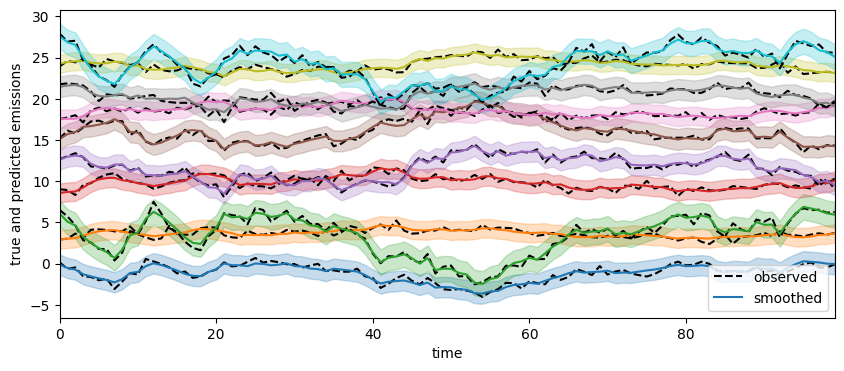

In [4]:
from itertools import count
state_dim = 2
emission_dim = 10
num_timesteps = 100

keys = map(jr.PRNGKey, count())

true_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(next(keys))

true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps)

num_iters = 100
test_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
test_params, test_param_props = test_model.initialize(next(keys))
test_params, marginal_lls = test_model.fit_em(test_params, test_param_props, emissions, num_iters=num_iters)

# Compute predicted emissions
emission_weights = test_params["emissions"]["weights"]
emission_bias = test_params["emissions"]["bias"]
emission_cov = test_params["emissions"]["cov"]
posterior = test_model.smoother(test_params, emissions)
smoothed_emissions = posterior.smoothed_means @ emission_weights.T + emission_bias
smoothed_emissions_cov = emission_weights @ posterior.smoothed_covariances @ emission_weights.T + emission_cov
smoothed_emissions_std = jnp.sqrt(jnp.array([smoothed_emissions_cov[:, i, i] for i in range(emission_dim)]))

spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions[:, i] - 2 * jnp.sqrt(smoothed_emissions_std[i]),
        spc * i + smoothed_emissions[:, i] + 2 * jnp.sqrt(smoothed_emissions_std[i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()

### Blocked Gibbs for LiearGaussianConjugateSSM

In [5]:
param_samples, lls = test_model.fit_blocked_gibbs(next(keys), test_params, sample_size=500, emissions=emissions)

plt.plot(lls)

ValueError: too many values to unpack (expected 2)

In [ ]:
@jit
def smooth_emission(params):
    posterior = lgssm_smoother(params, emissions)
    return posterior.smoothed_means @ params.emission_matrix.T + params.emission_bias

smoothed_emissions = jnp.array([smooth_emission(params) for params in param_samples])
smoothed_emissions_means = smoothed_emissions.mean(axis=0)
smoothed_emissions_stds = jnp.std(smoothed_emissions, axis=0)

In [ ]:
spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions_means[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions_means[:, i] - 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        spc * i + smoothed_emissions_means[:, i] + 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()